# Churn of bank clients


## Contents:

<a href="#step_1">1. Data preparation</a>

<a href="#step_2">2. Exploratory analysis</a>

<a href="#substep_1" style="margin-left: 20px;">2.1 Check imbalance of classes</a>

<a href="#substep_2" style="margin-left: 20px;">2.2 Logistic regression</a>

<a href="#substep_3" style="margin-left: 20px;">2.3 Random forest</a>

<a href="#substep_4" style="margin-left: 20px;">2.4 Model test</a>

<a href="#step_4">3. Conclusion</a>

<h2><a id="step_1" style="color: black; text-decoration: none;">1. Data preparation</a></h2>

At first we import all the necessary libraries then load raw dataset

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, make_scorer, roc_curve

In [2]:
#load data & check info
raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
#look at 5 first rows
raw_data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Problems identified:
- columns `RowNumber`, `CustomerId` and `Surname` are excessive  (not able to influence target)
- column names should be renamed (small letters, underscore)
- 899 missed values in `Tenure` - it may be changed to 0 (no real estate objects)
- a couple of categorical features that need to be transalted to dummy (`Geography`, `Gender`)
- scale of features vary a lot: some features are boolean (`HasCrCard`), others are measured in thousands (`Balance`), so standartisation is required after setting a training and a test datasets

In [4]:
#drop excessive columns
raw_data = raw_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [5]:
#rename columns
raw_data.columns = map(str.lower, raw_data.columns)
raw_data = raw_data.rename(columns={'creditscore': 'credit_score', \
                                    'numofproducts':'num_of_products', \
                                    'hascrcard': 'has_cr_card', \
                                    'isactivemember' : 'is_active_member', \
                                    'estimatedsalary': 'estimated_salary'})

In [6]:
#look at values of 'Tenure'
raw_data['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

Zero is one of `tenure` values (382 values), so missing values are due to other reasons (technical errors or no available data)

Check if proportion of target values (0 and 1) of missing values of `tenure` is similar to the proportion of available values

In [7]:
#look at proportion of target for missing values of 'tenure'
raw_data[raw_data['tenure'].isna()]['exited'].value_counts()

0    726
1    183
Name: exited, dtype: int64

In [8]:
#look at proportion of target
raw_data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

Proportions look similar (around 80% of zeros), share of missing values is less than 10%, so we can drop them

In [9]:
#drop missing values
raw_data = raw_data.dropna()

In [10]:
#create dummy features
raw_data = pd.get_dummies(raw_data, drop_first=True)
raw_data.columns = map(str.lower, raw_data.columns)
raw_data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [11]:
#create a new dataset
data = raw_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   float64
 3   balance            9091 non-null   float64
 4   num_of_products    9091 non-null   int64  
 5   has_cr_card        9091 non-null   int64  
 6   is_active_member   9091 non-null   int64  
 7   estimated_salary   9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_germany  9091 non-null   uint8  
 10  geography_spain    9091 non-null   uint8  
 11  gender_male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


<h2><a id="step_2" style="color: black; text-decoration: none;">2. Exploratory analysis</a></h2>

<h3><a id="substep_1" style="color: black; text-decoration: none;">2.1 Check imbalance of classes</a></h3>

In [12]:
#look at proportion of target
raw_data['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

There is imbalance of classes, only 20% of sample is 1 (the client churns)

In [13]:
#set target and features
target = data['exited']
features = data.drop('exited', axis = 1)

In [14]:
#set training and test datasets
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size = 0.25, random_state = 12345)
print('Size of train features:', features_train.shape)
print('Size of train target:', target_train.shape)
print('Size of test features:', features_test.shape)
print('Size of test target:', target_test.shape)

Size of train features: (6818, 11)
Size of train target: (6818,)
Size of test features: (2273, 11)
Size of test target: (2273,)


In [15]:
#upsample to balance classes (add 1 values)
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, \
                                                   random_state = 12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print('Size of train features:', features_upsampled.shape)
print('Size of train target:', target_upsampled.shape)

Size of train features: (11027, 11)
Size of train target: (11027,)


In [16]:
#standardise numeric features
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_upsampled[numeric])
features_upsampled[numeric] = scaler.transform(features_upsampled[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_upsampled.head()

<ipython-input-16-735dba62392e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])
/Users/tpummm/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
1574,0.302747,-1.712876,1.734005,0.548614,-0.751685,1,1,-0.171964,1,0,1
5983,-0.300952,-1.244756,0.362374,0.279766,0.737773,1,0,-0.913983,1,0,0
2115,-2.500872,1.189466,-0.323441,0.710672,-0.751685,1,0,-0.308095,1,0,0
5986,-1.242313,-0.589388,1.048190,-1.344570,-0.751685,1,0,-0.061964,0,1,0
4909,-0.536292,-1.151132,0.362374,-1.344570,0.737773,1,0,0.258946,0,1,0


<h3><a id="substep_2" style="color: black; text-decoration: none;">2.2 Logistic regression</a></h3>

In [17]:
#choose optimal hyperparameters in cross-validation
f1_metric = make_scorer(f1_score)

log_score = 0
log_solver = 'no'

for solv in ['saga', 'newton-cg','lbfgs', 'liblinear', 'sag']:
    scores = cross_val_score(LogisticRegression(random_state = 12345, solver = solv), \
                            features_upsampled, target_upsampled, scoring = f1_metric, cv = 3)
    score = scores.mean()
    if score > log_score:
        log_score = score
        log_solver = solv


print('Best solver:', log_solver)
print('Cross-validation F1:', log_score)

Best solver: sag
Cross-validation F1: 0.7044149272381625


<h3><a id="substep_3" style="color: black; text-decoration: none;">2.3 Random forest</a></h3>

In [18]:
#choose optimal hyperparameters in cross-validation
forest_score = 0
forest_depth = 0
for depth in range(1, 10):
    scores = cross_val_score(RandomForestClassifier(n_estimators = 10, max_depth = depth, random_state = 12345), \
                            features_upsampled, target_upsampled, scoring = f1_metric, cv = 5)
    score = scores.mean()
    if score > forest_score:
        forest_score = score
        forest_depth = depth

        
forest_score = 0
forest_estimators = 0
for estimator in range(1, 100):
    scores = cross_val_score(RandomForestClassifier(n_estimators = estimator, max_depth = forest_depth, \
                                                    random_state = 12345), \
                            features_upsampled, target_upsampled, scoring = f1_metric, cv = 5)
    score = scores.mean()
    if score > forest_score:
        forest_score = score
        forest_estimators = estimator
 

print('Best max depth:', forest_depth)
print('Best number of estimators:', forest_estimators)
print('Cross-validation F1:', forest_score)

Best max depth: 9
Best number of estimators: 93
Cross-validation F1: 0.8414131140570623


<h3><a id="substep_4" style="color: black; text-decoration: none;">2.4 Model test</a></h3>

In [19]:
#check results on test sample
model = RandomForestClassifier(n_estimators = forest_estimators, max_depth = forest_depth, random_state = 12345)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print('Test F1:', f1_score(target_test, predicted_test))

Test F1: 0.6027649769585254


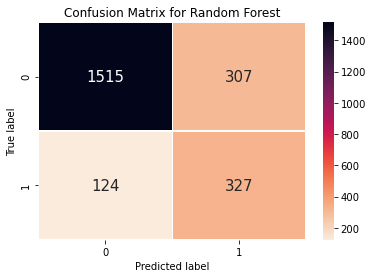

In [20]:
#check confusion matrix
matrix = confusion_matrix(target_test, predicted_test)
sns.heatmap(matrix, annot = True, annot_kws = {'size':15}, linewidths=0.2, \
            fmt = 'd', cmap = 'rocket_r')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [21]:
#compare with random model
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Test AUC-ROC:', auc_roc)

Test AUC-ROC: 0.8657891598375119


(0.0, 1.0)

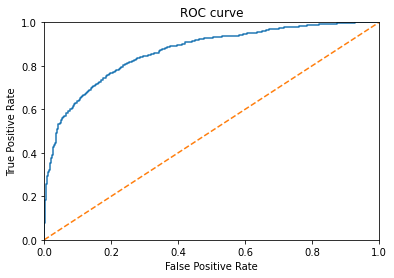

In [22]:
#ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve")

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0,1])
plt.ylim([0,1])

<h2><a id="step_4" style="color: black; text-decoration: none;">3. Conclusion</a></h2>

1. The best model basing on F1 metric is Random forest with max depth of 9 and 93 estimators
2. With cross-validation test sample shows F1 = 0.6
3. Quality of the model exceeds the one of random (AUC-ROC - 0.87)